In [1]:
from __future__ import print_function

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from scipy.optimize import minimize
from sklearn.metrics import average_precision_score


In [2]:

df = pd.read_csv('polyadb_features_pas_3_utr3.csv', sep='\t')

save_dict = np.load("polyadb_features_pas_3_utr3_no_x.npz")
m, l, c, y, _ = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

save_dict = np.load("polyadb_features_pas_3_utr3_saluki.npz")
hl, hl_m = np.mean(save_dict['hl'], axis=-1), save_dict['hl_m']

a_rich = np.zeros(m.shape)
for k in range(m.shape[1]) :
    a_rich[:, k] = df['pas_exists_' + str(k)] & df['wide_seq_ext_' + str(k)].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAAAAAAAA|AAAAAAGAAAAAA|AAAAAACAAAAAA")

#Define tissue-/cell- types

cell_types = np.array(['rpm',], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes

cell_type = 'rpm'

c = c[:, :, cell_type_dict[cell_type]]
y = y[:, :, cell_type_dict[cell_type]]

model_names = [
    'aparent2+hl',
    'aparent2+hl-lstm',
]

model_scores = [
    np.load('predictions/apa_polyadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores_utr3.npy'),
    np.load('predictions/apa_polyadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores_utr3.npy'),
]

use_saluki = [
    True,
    True,
]

use_lstm = [
    False,
    True,
]

print("s.shape = " + str(model_scores[0].shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("y.shape = " + str(y.shape))
print("c.shape = " + str(c.shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))
print("a_rich.shape = " + str(hl_m.shape))


s.shape = (10703, 10)
m.shape = (10703, 10)
l.shape = (10703, 10)
y.shape = (10703, 10)
c.shape = (10703, 10)

hl.shape = (10703, 10)
hl_m.shape = (10703, 10)
a_rich.shape = (10703, 10)


In [3]:
#Re-filter on max_n_pas

max_n_pas = 10

min_total_count = 0

m = m[:, :max_n_pas]
l = l[:, :max_n_pas]
c = c[:, :max_n_pas]
hl = hl[:, :max_n_pas]
hl_m = hl_m[:, :max_n_pas]

total_c = np.sum(c, axis=-1)
total_m = np.sum(m, axis=1)
max_l = np.max(l, axis=1)

m_cons = (np.sum(m, axis=-1) == np.sum(hl_m, axis=-1))

has_a_rich = np.sum(a_rich, axis=-1)

for model_ix in range(len(model_scores)) :
    model_scores[model_ix] = model_scores[model_ix][((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]

m = m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
l = l[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
c = c[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl = hl[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl_m = hl_m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]

y = c / np.sum(c, axis=1, keepdims=True)
y[np.isnan(y)] = 0.

print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(model_scores[0].shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))


m.shape = (7764, 10)
l.shape = (7764, 10)
c.shape = (7764, 10)
y.shape = (7764, 10)
s.shape = (7764, 10)

hl.shape = (7764, 10)
hl_m.shape = (7764, 10)


In [4]:

orig_l = np.copy(l)

l = np.log(orig_l * m + 1.)
cumul_l = np.log(np.cumsum(orig_l, axis=1) * m + 1.)
#l = np.log(np.cumsum(l[:, ::-1], axis=1)[:, ::-1] * m + 1.)


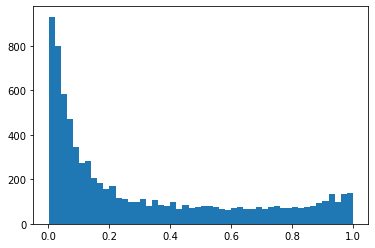

In [5]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i, dist_index[i]])

y_dist = np.array(y_dist)

f = plt.figure(figsize=(6, 4))

plt.hist(y_dist, bins=50)

plt.show()


In [6]:

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


Evaluating model = 'aparent2+hl'
[  0.48540947  -0.53888327  -0.05662315 -20.70917039   0.53392573
  -0.69835381  -0.11277431  -3.90498935]
Spearman r = 0.681
AP = 0.76
n = 7764


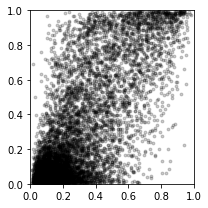

Evaluating model = 'aparent2+hl-lstm'
--- LSTM Cross-validation ---
Fold 0
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       [(None, 10, 4)]           0         
_________________________________________________________________
mask_input (Masking)         (None, 10, 4)             0         
_________________________________________________________________
final_bidir (Bidirectional)  (None, 32)                2688      
_________________________________________________________________
final_dense (Dense)          (None, 1)                 33        
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________
None
Try 0, val_loss = 0.1144
[Saving current best model.]
Try 1, val_loss = 0.1153
Try 2, val_loss = 0.1155
Fold 1
Try 0, val_loss = 0.1146
[Saving current best model.]
Try 1, val_l

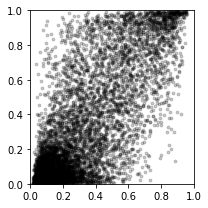

In [7]:
#Fit and evaluate regression / classification models on native measures

def logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask) :

    prox_exp = np.exp(w_prox_pas * s + w_prox_hl * hl + w_prox_len * l)
    dist_exp = np.exp(w_dist_pas * s + w_dist_hl * hl + w_dist_len * l)
    
    prox_score = np.sum(prox_exp * m * (1. - dist_mask), axis=1) + np.exp(w_prox_bias)
    dist_score = np.sum(dist_exp * m * dist_mask, axis=1) + np.exp(w_dist_bias)
    
    return dist_score / (dist_score + prox_score)

def logistic_model_mse(w_bundle, s, hl, m, l, dist_mask, y_true) :
    
    w_prox_pas = w_bundle[0]
    w_prox_hl = w_bundle[1]
    w_prox_len = w_bundle[2]
    w_prox_bias = w_bundle[3]
    w_dist_pas = w_bundle[4]
    w_dist_hl = w_bundle[5]
    w_dist_len = w_bundle[6]
    w_dist_bias = w_bundle[7]
    
    y_pred = logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = y_true_clip * np.log(y_true_clip / y_pred_clip) + (1. - y_true_clip) * np.log((1. - y_true_clip) / (1. - y_pred_clip))
    
    return np.mean(kl)

from sklearn.model_selection import KFold

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import tensorflow.keras.backend as K

def cross_val_model_lstm(s, hl, m, l, dist_mask, y_true, use_saluki=False, n_folds=10, n_tries=5, train_size=0.8) :
    
    print("--- LSTM Cross-validation ---")
    
    kf = KFold(n_splits=n_folds)
    
    y_pred = np.zeros(y_true.shape)
    
    n_layers = 1
    hidden_size = 16
    
    n_epochs = 500
    data_source = 'polyadb'
    train_models = True
    
    def _load_lstm(n_layers, hidden_size) :
        seq_input = tf.keras.layers.Input(shape=(10, 4), name='seq_input')

        masked_input = tf.keras.layers.Masking(mask_value=0., name='mask_input')(seq_input)

        for layer_ix in range(n_layers-1) :
            intermediate_lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True, name='intermediate_lstm_' + str(layer_ix))
            intermediate_bidir = tf.keras.layers.Bidirectional(intermediate_lstm, merge_mode='concat', name='intermediate_bidir_' + str(layer_ix))

            masked_input = intermediate_bidir(masked_input)

        lstm = tf.keras.layers.LSTM(hidden_size, name='final_lstm')
        bidir = tf.keras.layers.Bidirectional(lstm, merge_mode='concat', name='final_bidir')

        dense_out = bidir(masked_input)

        final_out = tf.keras.layers.Dense(1, activation='sigmoid', name='final_dense')(dense_out)

        model = tf.keras.models.Model(seq_input, final_out)
        
        return model
    
    def _kl_divergence(y_true, y_pred) :

        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

        return K.mean(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)
    
    for fold_ix, [train_index, test_index] in enumerate(kf.split(s)) :
        
        print("Fold " + str(fold_ix))
        
        n_train = int(s[train_index].shape[0] * train_size)
        
        s_train, s_val, s_test = s[train_index][:n_train], s[train_index][n_train:], s[test_index]
        hl_train, hl_val, hl_test = hl[train_index][:n_train], hl[train_index][n_train:], hl[test_index]
        m_train, m_val, m_test = m[train_index][:n_train], m[train_index][n_train:], m[test_index]
        l_train, l_val, l_test = l[train_index][:n_train], l[train_index][n_train:], l[test_index]
        dist_mask_train, dist_mask_val, dist_mask_test = dist_mask[train_index][:n_train], dist_mask[train_index][n_train:], dist_mask[test_index]
        y_train, y_val = y_true[train_index][:n_train], y_true[train_index][n_train:]
        
        x_train = np.concatenate([
            s_train[..., None],
            hl_train[..., None] if use_saluki else np.zeros(hl_train.shape),
            l_train[..., None],
            dist_mask_train[..., None],
        ], axis=-1) * m_train[..., None]
        
        x_val = np.concatenate([
            s_val[..., None],
            hl_val[..., None] if use_saluki else np.zeros(hl_val.shape),
            l_val[..., None],
            dist_mask_val[..., None],
        ], axis=-1) * m_val[..., None]
        
        x_test = np.concatenate([
            s_test[..., None],
            hl_test[..., None] if use_saluki else np.zeros(hl_test.shape),
            l_test[..., None],
            dist_mask_test[..., None],
        ], axis=-1) * m_test[..., None]
        
        if train_models :
        
            best_val_loss = np.inf
            for try_ix in range(n_tries) :

                model = _load_lstm(n_layers, hidden_size)
                model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0008, beta_1=0.5, beta_2=0.9), loss=_kl_divergence)
                
                if fold_ix == 0 and try_ix == 0 :
                    print(model.summary())
                
                callbacks = [
                    tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=50, restore_best_weights=True)
                ]
                
                model.fit(
                    x_train, y_train,
                    epochs=n_epochs,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(x_val, y_val),
                    verbose=False,
                    callbacks=callbacks
                )

                val_loss = model.evaluate(x_val, y_val, batch_size=64, verbose=False)

                print("Try " + str(try_ix) + ", val_loss = " + str(round(val_loss, 4)))

                if val_loss < best_val_loss :
                    best_val_loss = val_loss
                    print("[Saving current best model.]")
                    model.save_weights("saved_models/lstm_" + data_source + "_n_folds_" + str(n_folds) + "_n_tries_" + str(n_tries) + "_n_epochs_" + str(n_epochs) + "_n_layers_" + str(n_layers) + "_hidden_size_" + str(hidden_size) + "_fold_" + str(fold_ix) + ".h5")

        best_model = _load_lstm(n_layers, hidden_size)
        best_model.load_weights("saved_models/lstm_" + data_source + "_n_folds_" + str(n_folds) + "_n_tries_" + str(n_tries) + "_n_epochs_" + str(n_epochs) + "_n_layers_" + str(n_layers) + "_hidden_size_" + str(hidden_size) + "_fold_" + str(fold_ix) + ".h5")
        best_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0008, beta_1=0.5, beta_2=0.9), loss=_kl_divergence)
        
        y_pred[test_index] = best_model.predict(x=[x_test], verbose=False, batch_size=64)[:, 0]
        
    return y_pred

def cross_val_model(s, hl, m, l, dist_mask, y_true, use_saluki=False, n_folds=10) :
    
    kf = KFold(n_splits=n_folds)
    
    y_pred = np.zeros(y_true.shape)
    
    for fold_ix, [train_index, test_index] in enumerate(kf.split(s)) :
        
        s_train, s_test = s[train_index], s[test_index]
        hl_train, hl_test = hl[train_index], hl[test_index]
        m_train, m_test = m[train_index], m[test_index]
        l_train, l_test = l[train_index], l[test_index]
        dist_mask_train, dist_mask_test = dist_mask[train_index], dist_mask[test_index]
        y_true_train = y_true[train_index]
        
        w0 = np.zeros(8)

        res = minimize(logistic_model_mse, w0, args=(s_train, hl_train if use_saluki else 0., m_train, l_train, dist_mask_train, y_true_train), method='BFGS', options={'disp': False})

        w_prox_pas = res.x[0]
        w_prox_hl = res.x[1]
        w_prox_len = res.x[2]
        w_prox_bias = res.x[3]
        w_dist_pas = res.x[4]
        w_dist_hl = res.x[5]
        w_dist_len = res.x[6]
        w_dist_bias = res.x[7]

        if fold_ix == 0 :
            print(res.x)

        y_pred[test_index] = logistic_model_predict(s_test, hl_test if use_saluki else 0., m_test, l_test, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask_test)
    
    return y_pred

model_spearman_rs = np.zeros(len(model_scores))
model_aps = np.zeros(len(model_scores))
model_y_dist_preds = np.zeros((y_dist.shape[0], len(model_scores)))

for model_ix in range(len(model_scores)) :
    
    print("Evaluating model = '" + model_names[model_ix] + "'")
    
    s = model_scores[model_ix]
    
    if use_lstm[model_ix] :
        y_dist_pred = cross_val_model_lstm(s, hl, m, l, dist_mask, y_dist, use_saluki=use_saluki[model_ix], n_folds=20, n_tries=3)
    else :
        y_dist_pred = cross_val_model(s, hl, m, cumul_l, dist_mask, y_dist, use_saluki=use_saluki[model_ix], n_folds=20)
    
    spearman_r_val, _ = spearmanr(y_dist_pred, y_dist)
    model_spearman_rs[model_ix] = spearman_r_val
    
    y_labels = np.array([1. if y_dist[i] >= 0.5 else 0. for i in range(y_dist.shape[0])])
    
    ap = average_precision_score(y_labels, y_dist_pred)
    model_aps[model_ix] = ap
    model_y_dist_preds[:, model_ix] = y_dist_pred[:]

    print("Spearman r = " + str(round(spearman_r_val, 3)))
    print("AP = " + str(round(ap, 2)))
    print("n = " + str(y_dist.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_dist_pred, y_dist, color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


In [8]:
#Save metrics

np.save("native_apa_multi_polyadb_w_saluki_lstm_1_16_cv_20_spearman_rs", model_spearman_rs)
np.save("native_apa_multi_polyadb_w_saluki_lstm_1_16_cv_20_aps", model_aps)
np.save("native_apa_multi_polyadb_w_saluki_lstm_1_16_cv_20_y_dist_preds", model_y_dist_preds)
np.save("native_apa_multi_polyadb_w_saluki_lstm_1_16_cv_20_orig_l", orig_l)
np.save("native_apa_multi_polyadb_w_saluki_lstm_1_16_cv_20_hl", hl)
np.save("native_apa_multi_polyadb_w_saluki_lstm_1_16_cv_20_y_dist", y_dist)
